# 뉴스 기사를 크롤링 &새로운 뉴스 카테고리 예측 모델 만들기

이번 시간에는 뉴스를 크롤링하고, 뉴스의 카테고리를 예측하는 머신러닝 모델을 만들어봅시다.

먼저 필요한 모듈들을 설치해줍니다.

```bash
$pip install bs4
$pip install newspaper3k
$pip install konlpy
```

## 1. 데이터 불러오기

먼저, 뉴스 기사를 크롤링 한 csv파일을 읽어옵니다.

In [2]:
import pandas as pd

df = pd.read_csv('./data/news_data.csv', sep=',')

In [3]:
df[:10]

,news,code
0,파주시청. 사진제공=파주시 파주시청. 사진제공=파주시\n\n[파주=파이낸셜뉴스 강근...,사회
1,동영상 뉴스\n\n이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의...,사회
2,황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검. 사진...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회
5,질서정연 코로나19 확산 방지를 위한 ‘물리적 거리 두기’가 ‘생활 속 거리 두기’...,사회
6,“코로나19에 걸렸다 나은 친구는 아무래도 좀 멀리하게 될 것 같아요. 재발 가능성...,사회
7,1977년 메이저리그 LA 다저스의 시즌 마지막 경기였다. 신인 타자 더스티 베이커...,사회
8,"6일 등교수업을 앞둔 경북 한 학교의 보건실에는 손소독제, 마스크 등 방역물품이 상...",사회
9,경찰 로고./뉴스1 © News1 신채린 기자 경찰 로고./뉴스1 © News1 신...,사회


## 2. 데이터 전처리

이제 이 뉴스 데이터에 대해 전처리를 진행해야하는데, 이 nenw 데이터는 각종 HTML 태그들이 섞여있습니다. 먼저, 한글 외에는 전부 제거하도록 **정규표현식**을 이용하여 전처리를 진행합니다. 

In [4]:
# 정규표현식 이용해 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]", "")
df['news']

0       파주시청 사진제공파주시 파주시청 사진제공파주시파주파이낸셜뉴스 강근주 기자 파주시는 ...
1       동영상 뉴스이천 물류창고 화재 발화지점으로 지목된 지하 층에서 산소절단기의 산소 공...
2       황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검 사진제...
3       귀갓길 여성을 쫓아가 성범죄를 시도한 대 남성이 구속됐습니다서울 강남경찰서는 강간상...
4       서울연합뉴스 대한약사회가 일부터 코로나바이러스 감염증 대응 체계를 사회적 거리두기에...
                              ...                        
5119    신종 코로나바이러스 감염증코로나 사태 이후 가정의 달 월에도 언택트비대면 신풍속도가...
5120    는 소비자로부터 월 이용료 만만원을 받고 초고속 인터넷을 제공한다 그런 브로드밴드가...
5121    머리를 긁고 있는 오랑우탄 몸을 긁는 행동을 따라 하는 것은 부정적 감정과 관련이 ...
5122    가 오는 일 정식 출시하는 스마트폰 벨벳이 사실상 공짜폰이 될 전망이다 단말기 가격...
5123    이미지제공게티이미지뱅크 이미지제공게티이미지뱅크  전자신문  전자신문인터넷 무단전재 ...
Name: news, Length: 5124, dtype: object

그리고 데이터에 **Null**값이 있는지 확인해봅시다.

In [5]:
print(df.isnull().sum())

news    0
code    0
dtype: int64


**null**값을 가진 샘플은 없습니다. 그러면 중복은 있을까요?

중복을 제거해봅시다.

In [6]:
# 중복된 샘플을 제거합니다.
df.drop_duplicates(subset=['news'], inplace = True)

print('뉴스 기사의 개수 : ', len(df))

뉴스 기사의 개수 :  3994


와! 엄청 많이 줄었네요!!

## 3. 데이터 탐색

이제 각 카테고리별 샘플의 분포를 확인해봅시다.

먼저 matplotlib에서는 한글이 깨지는데, ubuntu 환경인 경우에는 아래와 같은 방법으로 한글 글꼴을 설치해봅시다. 

```bash
$sudo apt-get install fonts-nanum*
$sudo fc-cache-fv
$sudo cp /usr/share/fonts/truetype/nanum/Nanum* /usr/local/lib/python3.4/dist-packages/matplotlib/mpl-data/fonts/ttf/
$rm -rf home/ubuntu/.cache/matplotlib/*
```


In [7]:
import matplotlib
import matplotlib.font_manager

#print(matplotlib.__file__)
#!cp /usr/share/fonts/truetype/nanum/Nanum* /home/aiffel0039/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/

[f.name for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name]

[]

/home/aiffel0039/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0039/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0039/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0039/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54876 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0039/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0039/anaconda3/lib/python3.7/site-packages/matplotlib

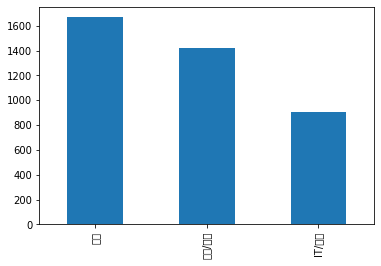

In [8]:
import matplotlib.pyplot as plt

df['code'].value_counts().plot(kind = 'bar')

## 4. 토큰화

자연어 처리에서 대부분의 경우 문자열은 특정 단위로 나누어져야만합니다. 자연어 처리에서는 이 특정 단위를 '토큰(token)'이라고 하며 이 과정은 토큰화(tokenization) 또는 토크나이징(tokenizing)이라고 합니다. 

토큰을 찾고 분석하기 위해서는 형태소 패키지 라이브러리, **Mecab**을 설치해야 합니다. 

OS별로 설치 방법이 다르니, 아래 링크에서 확인해보세요!

<https://konlpy.org/en/latest/install/>

Mecab의 `.morphs`를 사용하면 입력 문자열을 형태소 단위로 나누어줍니다.

In [9]:
from konlpy.tag import Mecab
tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']


입력된 문자열이 토큰화 된 것을 볼 수 있습니다. 자연어 처리에서는 토큰화 결과가 얼마나 정확한지에 따라 그 성능에 많은 영향을 받기 때문에 항상 조심해주는 것이 좋습니다.

### 불용어(stopwords) 제거

이제 형태소 분석기를 사용해 토큰화 전처리를 해봅시다. 바로 불용어를 제거해주는 것인데요, **불용어**란 데이터 전체에서 꽤 많이 등장하지만 자연어 처리에 큰 영향을 주지 않는, 중요하지 않은 단어들을 말합니다. 주로 조사나 접사 등이 불용어에 속합니다. 

이 데이터의 불용어를 정의해봅시다.

In [10]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

불용어는 미리 짐작하여 한번에 정의하는 것이 아니라, 토큰화 과정을 거친 결과를 _지속적으로 확인하면서 계속해서 추가하는 것이 일반적_ 입니다. 

토큰화 및 토큰화 과정에서 불용어를 제거하는 함수를 만들어봅시다.

In [16]:
def preprocessing(data):
    text_data = []
    
    for sentence in data:
        temp_data = []
        # 토큰화
        temp_data = tokenizer.morphs(sentence)
        # 불용어 제거
        temp_data = [word for word in temp_data if not word in stopwords]
        text_data.append(temp_data)
    
    text_data = list(map(' '.join, text_data))
    
    return text_data

In [17]:
text_data = preprocessing(df['news'])
print(text_data[0])

파주 시청 사진제 공파 주시 파주 시청 사진 제공 파주시 파주 강근주 파 주 시 일 관내 취약 계층 만 가구 대해 정부 긴급 재난 지원금 입금 완료 다파 주 시민 받 긴급 재난 지원금 인 이상 가구 기준 으로 만 원 받 게 되 며 인 가구 만 원 인 가구 만 원 인 가구 만 원 정부 발표 긴급 재난 지원금 파주 시민 지급 금액 다른 이유 국비 지방비 부담 비율 다파 주 시 이미 모든 시민 경기도 파주시 재난 기본 소득 인 당 각 만 원 지급 고 어 시민 국비 지원금 만 지급 며 인 가구 기준 으로 총 지원 금액 파주시 재난 기본소득 만 원 경기도 재난 기본소득 만 원 정부 긴급 재난 지원금 만 원 총 만 원 받 게 된다 취약 계층 아닌 시민 오 월일 부터 소지 고 신용 체크카드 사 홈페이지 에서 긴급 재난 지원금 지원 신청 세대주 가족 지원금 일괄 신청 해야 한다 한편 파 주 시 일 김정기 부시장 단장 으로 긴급 재난 지원금 추진 태 스 크 포스 를 구성 해 긴급 재난 지원금 원활 게 지급 될 도록 지원 한다 권 자 재 배포


불용어가 제거된 상태로, 띄어쓰기 단위로 토큰화 된 데이터라고 볼 수 있습니다. 

## 5. 머신러닝  사용하기

데이터에 대한 전처리가 끝났습니다. 이제 머신러닝 모델을 적용해보도록 해요.

우리가 사용할 머신러닝 모델은 **나이브 베이즈 분류기**라는 모델입니다. 나이브 베이즈 분류기는 아래 영상에서 확인해보세요!

- 나이브 베이즈 : <https://www.youtube.com/watch?v=3JWLIV3NaoQ&feature=emb_title>


### 5.1 필요한 라이브러리 및 모듈 import

우선 머신러닝 모델 적용을 위해 필요한 도구를 import 합니다.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

사이킷런(scikit-learn 또는 sklearn)는 훈련 데이터와 테스트 데이터를 분리하는데 유용한 `train_test_split()` 함수를 제공합니다. `train_test_split()`에 사용할 데이터를 입력하면 훈련 데이터와 테스트 데이터로 분리해줍니다.

In [20]:
# 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(
    text_data,
    df['code'],
    random_state = 0)

print("훈련용 뉴스 기사의 개수 : ", len(X_train))
print("테스트용 뉴스 기사의 개수 : ", len(X_test))
print("훈련용 레이블의 개수 : ", len(y_train))
print("테스트용 레이블의 개수 : ", len(y_test))

훈련용 뉴스 기사의 개수 :  2995
테스트용 뉴스 기사의 개수 :  999
훈련용 레이블의 개수 :  2995
테스트용 레이블의 개수 :  999


기계는 텍스트보다는 숫자를 더 잘 처리합니다. 머신러닝 모델인 나이브 베이즈 분류기를 사용하기 위해서는 각 뉴스의 텍스트 데이터를 벡터로 변환할 필요가 있습니다. 이를 위해 전처리로 **TF-IDF**라는 방법을 사용하겠습니다.

TF-IDF에 대해서는 아래 링크에서 확인해보세요!

<https://www.youtube.com/watch?v=meEchvkdB1U&feature=emb_title>

각 뉴스 문서를 TF-IDF 벡터로 바꾸고, 이를 통해 나이브 베이즈 분류기를 학습해봅시다.

`fit_transform()` 함수는 fir과 transform을 연이어 수행하는 함수로, `CountVectorizer.fit_transform()`은 단어 데이터를 학습하고 문서 데이터를 document-form matrix로 변환하는 두가지 작업을 해줍니다.

In [22]:
#단어의 수를 카운트하는 사이킷런의 카운트벡터라이저
count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)

# 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# 나이브베이즈 분류기를 수행ㅎ압니다.
# X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

나이브 베이즈 분류기가 학습되었습니다. 모델이 학습되었다면 그 다음 해야 할 일은 바로 '테스트'입니다. 이 모델이 제대로 학습되었는지를 확인해봐야겠죠?

텍스트를 입력하면 자동으로 TF-IDF 벡터로 바꾸는 전처리 함수를 만들어보겠습니다. 이 함수를 통해 텍스트를 바로 나이브베이즈 분류기의 입력으로 사용함으로써 보다 용이하게 테스트 할 수 있습니다.

In [25]:
def tfidf_vectorizer(data):
    data_counts = count_vec.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

임의의 뉴스에 대해서 카테고리를 확인해봅시다. 이 뉴스들은 훈련 데이터, 테스트 데이터 그 어디에도 속하지 않는 임의로 가져온 뉴스입니다. `clf.predict()`는 임의의 입력에 대해서 나이브 베이즈 분류기가 예측한 값을 리턴합니다.

In [26]:
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['사회']


내용을 봤을 때, 사회 뉴스로 예측하는 것이 적절합니다.

In [27]:
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


영화 관련 뉴스에서는 생활/문화 뉴스로 예측하네요!

In [28]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['IT/과학']


LG전자의 LG벨벳 뉴스에 대해서는 IT/과학 뉴스라고 예측하고 있습니다. 이제 테스트 데이터에 대해서 모델을 예측하게 하고, 실제 값과 비교하여 점수를 측정해봅시다.

In [29]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.90      0.74      0.81       236
          사회       0.79      0.91      0.85       422
       생활/문화       0.81      0.76      0.79       341

    accuracy                           0.82       999
   macro avg       0.83      0.80      0.81       999
weighted avg       0.82      0.82      0.82       999



머신러닝 모델의 성능 측정 방법 중 하나인 F1-Score에서 81%의 준수한 정확도를 얻어냈습니다! 

F1 스코어에 대해서는 아래 링크에서 확인해주세요!

- F1 스코어 : <http://seb.kr/w/F1_%EC%8A%A4%EC%BD%94%EC%96%B4>